In [8]:
from src.data import gedi_pipeline

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

sns.set_theme()
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from src.processing.rf import train
from fastbook import *

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-10-28 17:50:15,500 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 17:50:15,501 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 17:50:15,502 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 17:50:15,504 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [9]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [3]:
gedi_unburned = load_pickle(f"{DATA_PATH}/gedi_intermediate/filtered_unburned_shots.pkl")

In [25]:
def train_rf(columns_to_use, dep_var, log=True):
    df = gedi_unburned[columns_to_use].dropna()
    if log:
        df = df[df[dep_var] != 0]
        df[dep_var] = np.log(df[dep_var])
    df = df.dropna()
    procs = [Categorify, FillMissing]
    cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
    to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
    xs, y = to.train.xs, to.train.y
    m = rf(xs, y)
    rmse_train = train.m_rmse(m, xs, y)
    r2_train = train.m_r2(m, xs, y)
    print(rmse_train, r2_train)
    return m, xs, y

In [4]:
gedi_unburned.columns

Index(['shot_number', 'beam_type', 'absolute_time', 'longitude', 'latitude',
       'elevation_difference_tdx', 'agbd', 'agbd_se', 'fhd_normal', 'pai',
       'pai_z', 'pavd_z', 'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover',
       'cover_z', 'sensitivity_a0', 'solar_elevation', 'gridded_pft_class',
       'geometry', 'gedi_year', 'gedi_month', 'severity', 'burn_year',
       'burn_count', 'time_since_burn', 'aspect_2x2', 'aspect_mean',
       'aspect_std', 'aspect_median', 'elevation_2x2', 'elevation_mean',
       'elevation_std', 'elevation_median', 'slope_2x2', 'slope_mean',
       'slope_std', 'slope_median', 'soil_2x2', 'soil_mean', 'soil_std',
       'soil_median', 'SR_B1_2x2', 'SR_B1_mean', 'SR_B1_std', 'SR_B1_median',
       'SR_B2_2x2', 'SR_B2_mean', 'SR_B2_std', 'SR_B2_median', 'SR_B3_2x2',
       'SR_B3_mean', 'SR_B3_std', 'SR_B3_median', 'SR_B4_2x2', 'SR_B4_mean',
       'SR_B4_std', 'SR_B4_median', 'SR_B5_2x2', 'SR_B5_mean', 'SR_B5_std',
       'SR_B5_median', 'SR_B6_2x2', '

# Predicting AGBD on unfiltered Unburned areas

# Predicting on filtered Unburned areas

# Predicting RH_98 based on terrain and elevation difference tdx

In [39]:
columns_to_use = ['elevation_difference_tdx',
                  'rh_98',
                  'solar_elevation',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98", log=False)

7.498028 0.4812526063710555


                       cols       imp
0  elevation_difference_tdx  0.689498
3          elevation_median  0.113186
4              slope_median  0.089940
1           solar_elevation  0.044519
2             aspect_median  0.037713
5               soil_median  0.025145


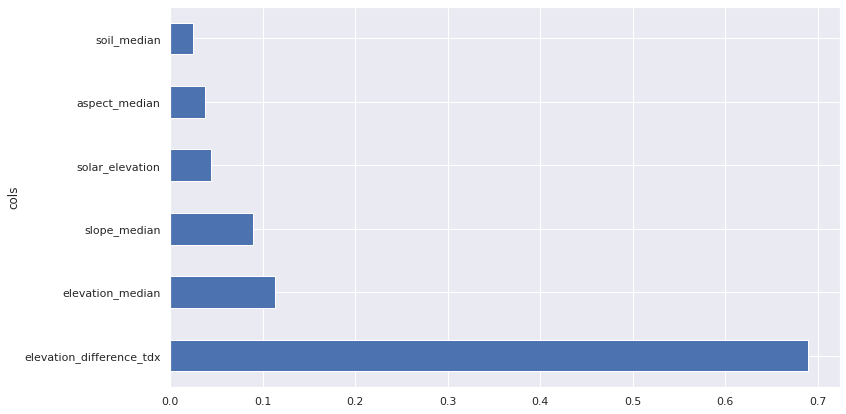

In [40]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

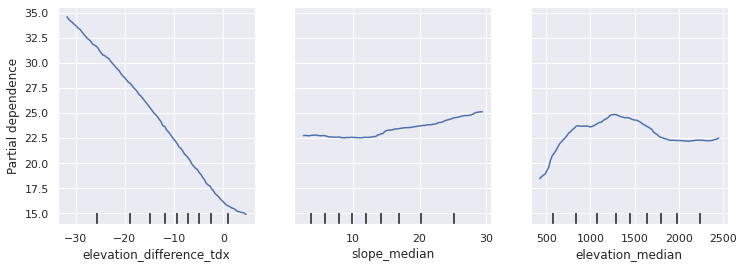

In [42]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'slope_median', 'elevation_median'], ax=ax)

# Predicting RH_98 only based on terrain

In [36]:
columns_to_use = ['rh_98',
                  'solar_elevation',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98", log=False)

8.811767 0.2835467721296482


               cols       imp
2  elevation_median  0.357462
3      slope_median  0.223229
0   solar_elevation  0.208754
1     aspect_median  0.111525
4       soil_median  0.099030


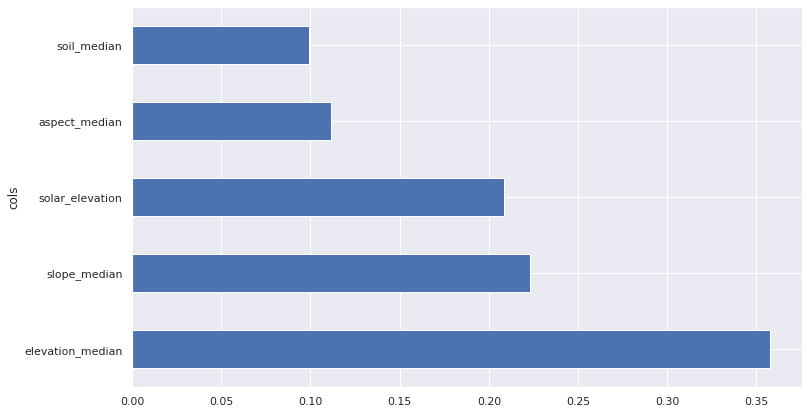

In [37]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

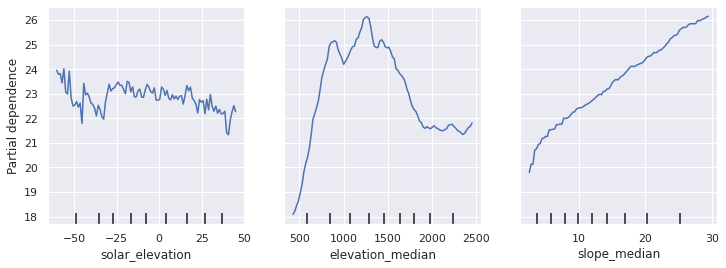

In [38]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['solar_elevation', 'elevation_median', 'slope_median'], ax=ax)

# Predicting RH_98 without any other Landsat bands

In [33]:
columns_to_use = ['NDVI_mean',
                  'rh_98',
                  'solar_elevation',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98", log=False)

8.160002 0.3856292298921027


               cols       imp
0         NDVI_mean  0.550366
3  elevation_median  0.182188
4      slope_median  0.091362
1   solar_elevation  0.080854
2     aspect_median  0.058844
5       soil_median  0.036387


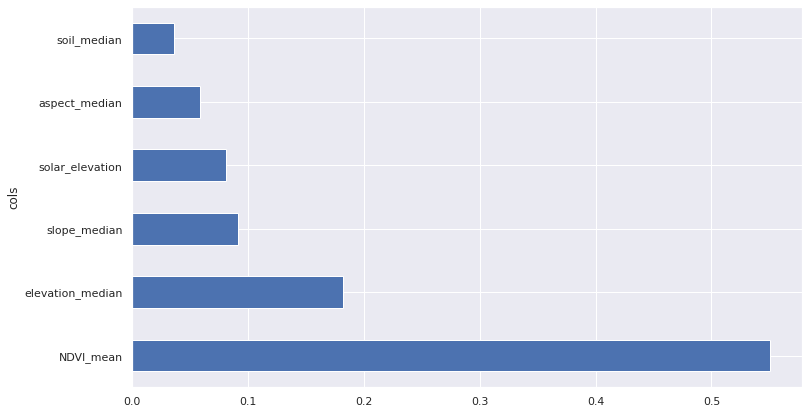

In [34]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

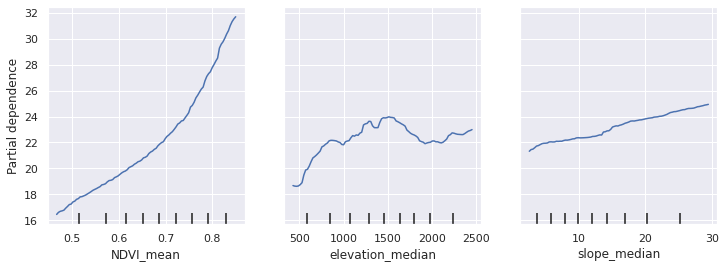

In [35]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['NDVI_mean', 'elevation_median', 'slope_median'], ax=ax)

# Predicting RH_98 without any GEDI metrics

In [29]:
columns_to_use = ['SR_B1_mean', 'SR_B2_mean', 'SR_B3_mean', 'SR_B4_mean',
                  'SR_B5_mean', 'SR_B6_mean', 'SR_B7_mean', 
                  'NDVI_mean',
                  'rh_98',
                  'solar_elevation',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98", log=False)

7.354872 0.5008854594747245


                cols       imp
6         SR_B7_mean  0.296291
5         SR_B6_mean  0.181941
3         SR_B4_mean  0.093931
10  elevation_median  0.071964
2         SR_B3_mean  0.067501
9      aspect_median  0.048773
4         SR_B5_mean  0.045171
11      slope_median  0.042528
1         SR_B2_mean  0.041046
7          NDVI_mean  0.040828


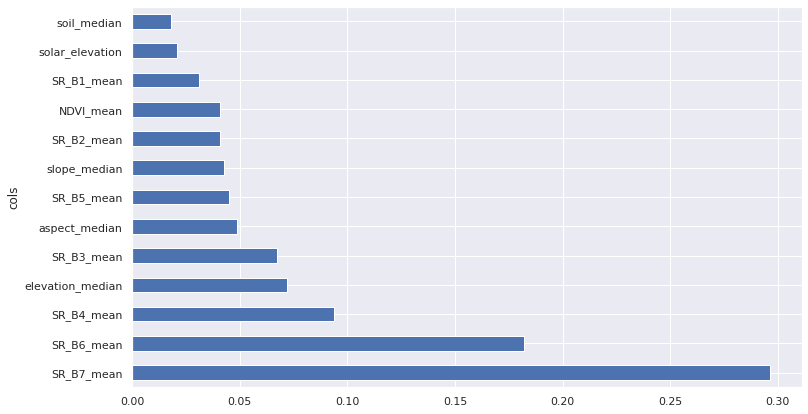

In [30]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

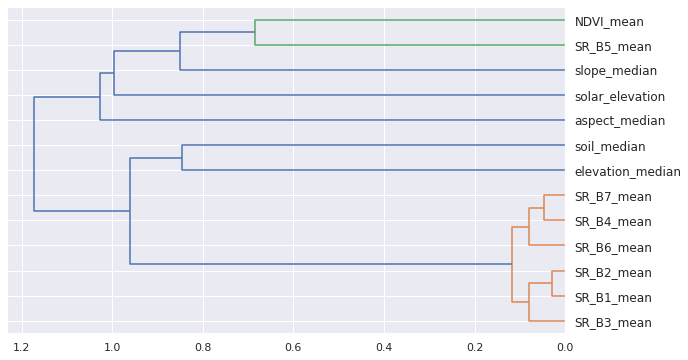

In [31]:
cluster_columns(xs)

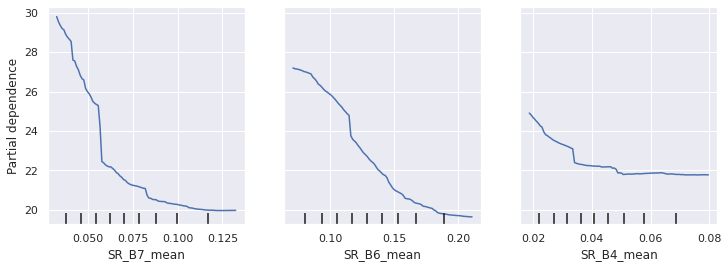

In [32]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['SR_B7_mean', 'SR_B6_mean', 'SR_B4_mean'], ax=ax)

# Predicting RH_98 without pai and cover

In [26]:
columns_to_use = ['SR_B1_mean', 'SR_B2_mean', 'SR_B3_mean', 'SR_B4_mean',
                  'SR_B5_mean', 'SR_B6_mean', 'SR_B7_mean', 
                  'NDVI_mean',
                  'rh_98',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98", log=False)

6.605053 0.5974659554199568


                        cols       imp
8   elevation_difference_tdx  0.409184
6                 SR_B7_mean  0.157445
5                 SR_B6_mean  0.143765
3                 SR_B4_mean  0.053067
10            sensitivity_a0  0.038194
13              slope_median  0.037194
12          elevation_median  0.034108
2                 SR_B3_mean  0.028346
11             aspect_median  0.022554
4                 SR_B5_mean  0.020166


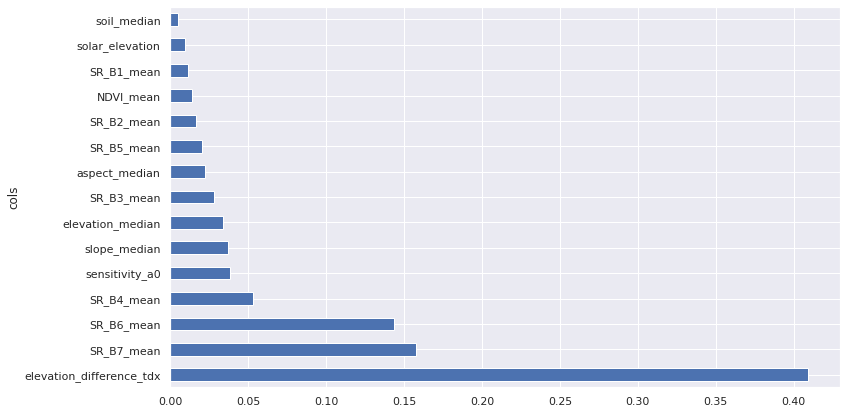

In [27]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

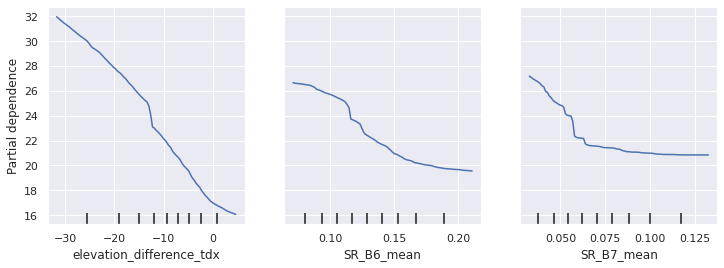

In [28]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'SR_B6_mean', 'SR_B7_mean'], ax=ax)

# Predicting RH_98 with no RH metrics

RH 98 prediction R^2 = 0.73.

In [17]:
columns_to_use = ['SR_B1_mean', 'SR_B2_mean', 'SR_B3_mean', 'SR_B4_mean',
                  'SR_B5_mean', 'SR_B6_mean', 'SR_B7_mean', 
                  'NDVI_mean',
                  'rh_98', 'cover', 'pai',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98")

0.276889 0.7307208705214985


                        cols       imp
9                        pai  0.279758
8                      cover  0.265224
10  elevation_difference_tdx  0.168415
5                 SR_B6_mean  0.071187
6                 SR_B7_mean  0.038503
14          elevation_median  0.037115
15              slope_median  0.026722
3                 SR_B4_mean  0.023096
12            sensitivity_a0  0.020574
4                 SR_B5_mean  0.014216


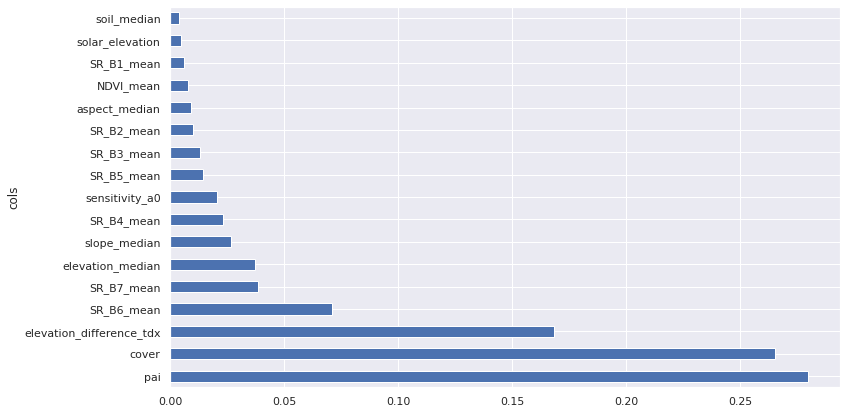

In [20]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

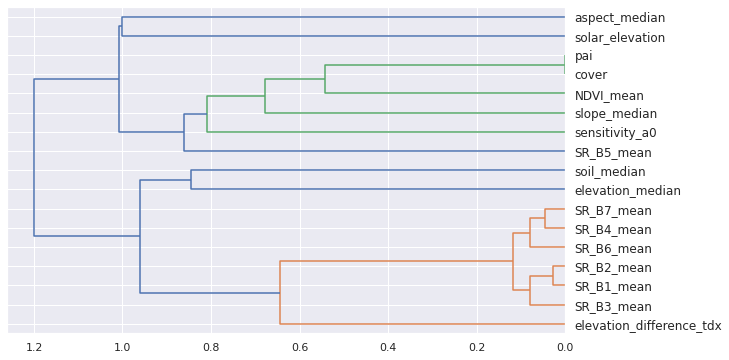

In [19]:
cluster_columns(xs)

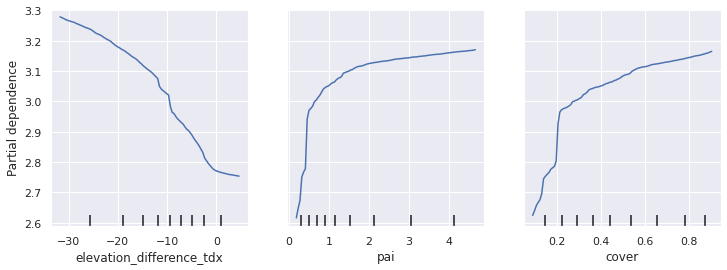

In [21]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'pai', 'cover'], ax=ax)

# Predicting RH_98 with everything but AGBD

RH 98 prediction R^2 = 0.86.

In [13]:
columns_to_use = ['SR_B1_mean', 'SR_B2_mean', 'SR_B3_mean', 'SR_B4_mean',
                  'SR_B5_mean', 'SR_B6_mean', 'SR_B7_mean', 
                  'NDVI_mean',
                  'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover', 'pai',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
m, xs, y = train_rf(columns_to_use, "rh_98")

0.198035 0.8622555711266189


                        cols       imp
9                      rh_70  0.447883
13                       pai  0.136586
12                     cover  0.134985
10                     rh_50  0.098215
14  elevation_difference_tdx  0.047442
11                     rh_25  0.028144
18          elevation_median  0.024333
0                  beam_type  0.022439
6                 SR_B6_mean  0.012086
16            sensitivity_a0  0.010708


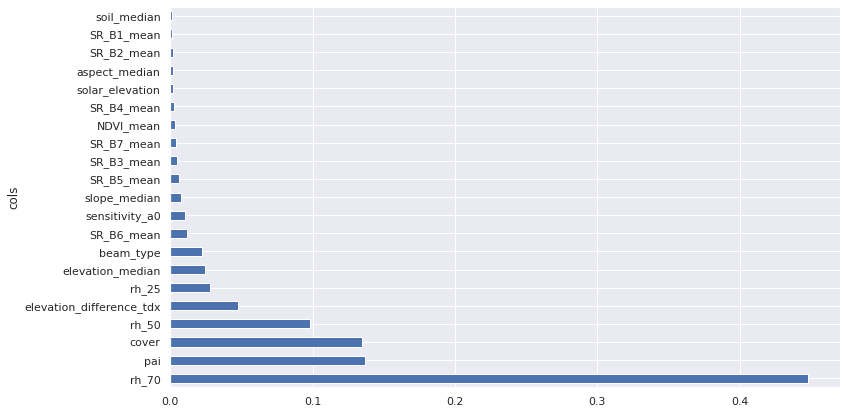

In [14]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

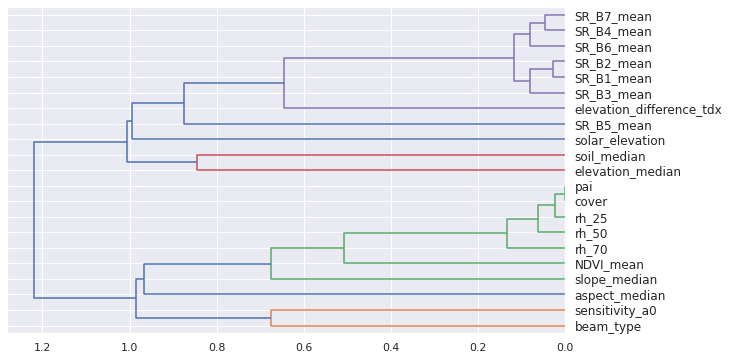

In [15]:
cluster_columns(xs)

# Predicting PAI without elevation difference

In [164]:
0.42

0.42

In [162]:
columns_to_use = ['NDVI_mean',
                  'pai',
                  'beam_type',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [163]:
dep_var = 'pai'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.797669 0.4267712045510679


               cols       imp
1         NDVI_mean  0.391544
3    sensitivity_a0  0.165170
6      slope_median  0.163909
0         beam_type  0.112219
5  elevation_median  0.079741
2   solar_elevation  0.043871
4     aspect_median  0.035256
7       soil_median  0.008292


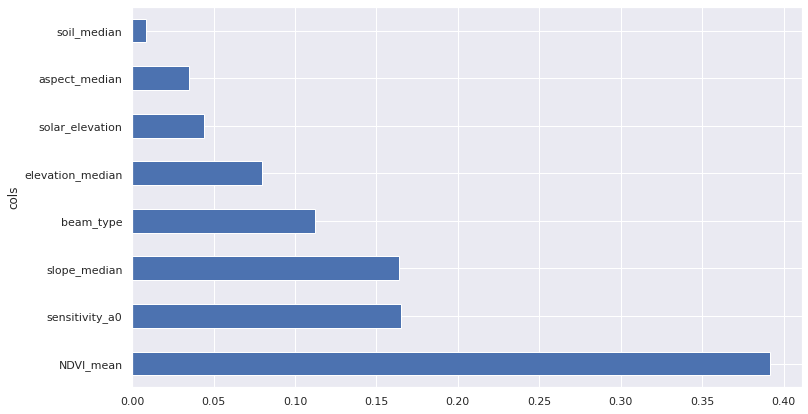

In [165]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

In [167]:
df.drop(columns="beam_type").corr()

,NDVI_mean,pai,solar_elevation,sensitivity_a0,aspect_median,elevation_median,slope_median,soil_median
NDVI_mean,1.000000,0.411350,0.004648,0.162348,0.023178,-0.211163,0.207080,-0.084837
pai,0.411350,1.000000,0.000284,0.196945,0.025066,-0.147072,0.322317,-0.018155
solar_elevation,0.004648,0.000284,1.000000,-0.068227,-0.001155,-0.022336,-0.003086,-0.015361
sensitivity_a0,0.162348,0.196945,-0.068227,1.000000,0.024027,-0.028382,0.175524,0.004104
aspect_median,0.023178,0.025066,-0.001155,0.024027,1.000000,-0.002224,0.061503,-0.004935
elevation_median,-0.211163,-0.147072,-0.022336,-0.028382,-0.002224,1.000000,0.009652,0.054444
slope_median,0.207080,0.322317,-0.003086,0.175524,0.061503,0.009652,1.000000,0.023330
soil_median,-0.084837,-0.018155,-0.015361,0.004104,-0.004935,0.054444,0.023330,1.000000


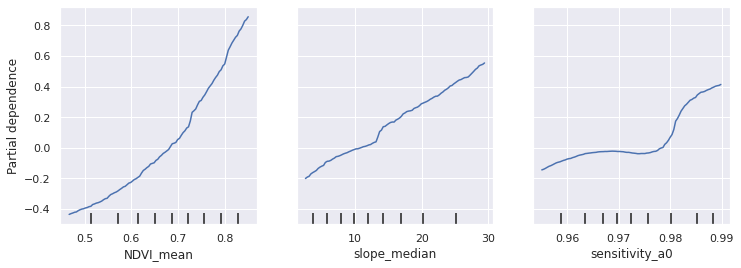

In [168]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['NDVI_mean', 'slope_median', 'sensitivity_a0'], ax=ax)


# Predicting PAI without GEDI variables

0.49 R^2.

In [157]:
columns_to_use = ['NDVI_mean',
                  'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [158]:
dep_var = 'pai'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.751582 0.4910967255887636


                       cols       imp
2  elevation_difference_tdx  0.313002
1                 NDVI_mean  0.247031
4            sensitivity_a0  0.120839
7              slope_median  0.116111
0                 beam_type  0.083999
6          elevation_median  0.064030
3           solar_elevation  0.025137
5             aspect_median  0.024669
8               soil_median  0.005183


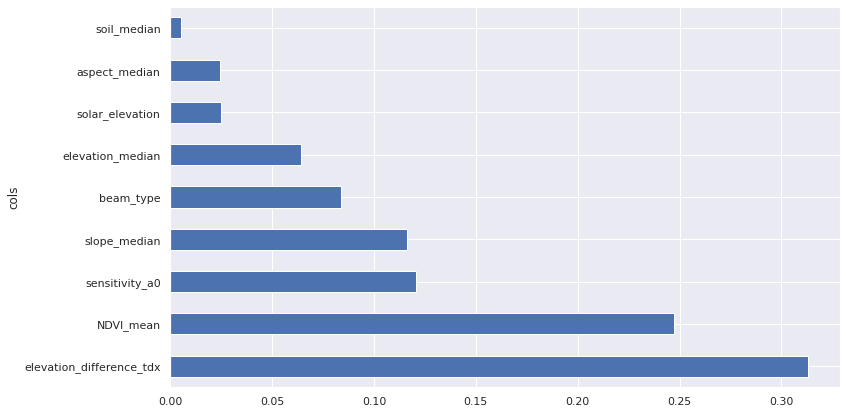

In [159]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

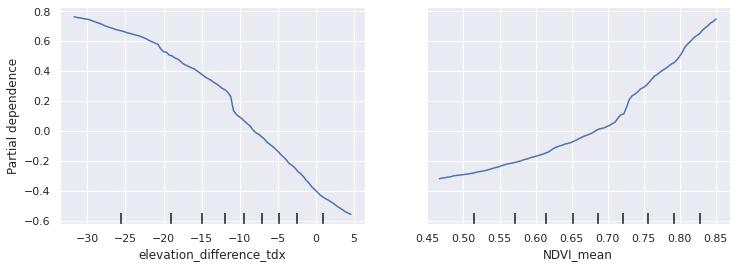

In [160]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'NDVI_mean'], ax=ax)


# Predicting PAI without RH variables

0.82 R^2

In [153]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [154]:
dep_var = 'pai'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.439995 0.8255877750121146


                       cols       imp
1                      agbd  0.723753
3  elevation_difference_tdx  0.072933
2                 NDVI_mean  0.051933
8              slope_median  0.047224
0                 beam_type  0.039205
5            sensitivity_a0  0.028449
7          elevation_median  0.025556
6             aspect_median  0.004911
4           solar_elevation  0.004698
9               soil_median  0.001337


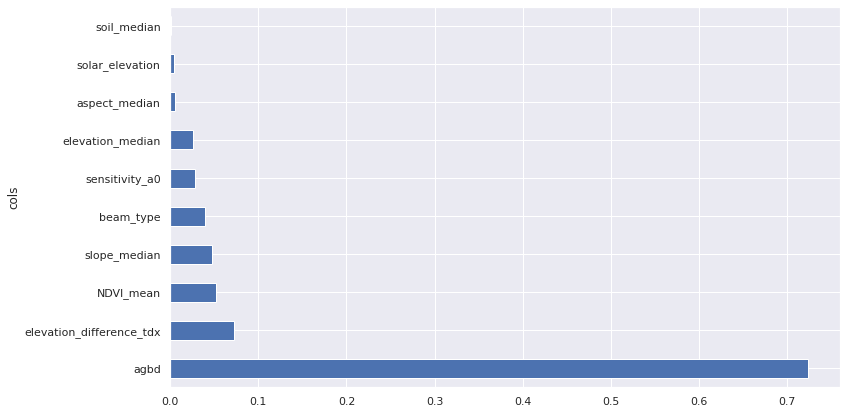

In [155]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

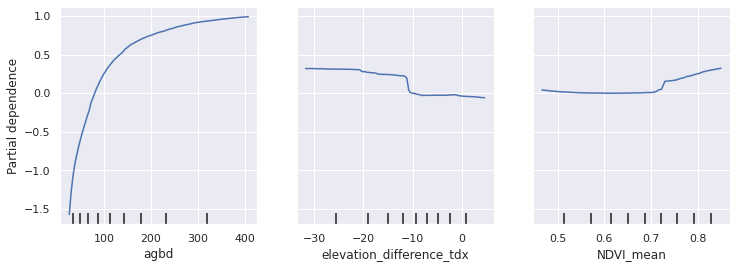

In [156]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['agbd', 'elevation_difference_tdx', 'NDVI_mean'], ax=ax)


# Predicting PAI without cover

0.98 R^2, with rh metrics as highest predictors. Interesting dependency curves.

In [144]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'rh_98', 'rh_70', 'rh_50', 'rh_25', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [145]:
dep_var = 'pai'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.143631 0.981414435885652


                        cols       imp
6                      rh_25  0.487167
5                      rh_50  0.319281
4                      rh_70  0.113881
1                       agbd  0.050331
3                      rh_98  0.015336
7   elevation_difference_tdx  0.004851
2                  NDVI_mean  0.003090
12              slope_median  0.002354
0                  beam_type  0.001689
9             sensitivity_a0  0.000984


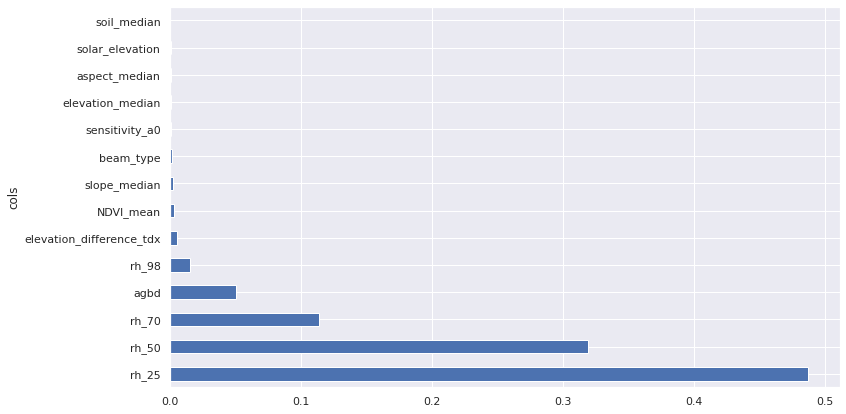

In [146]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

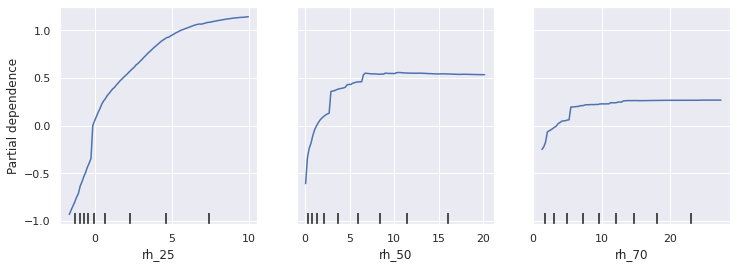

In [147]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['rh_25', 'rh_50', 'rh_70'], ax=ax)


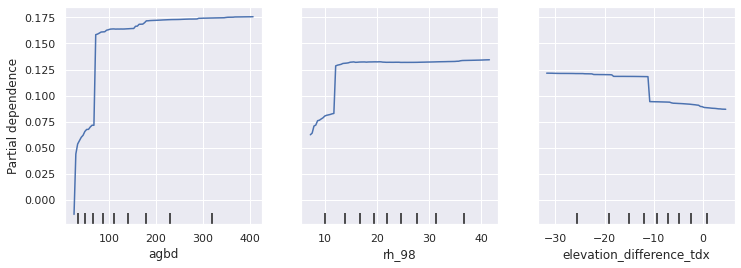

In [148]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['agbd', 'rh_98', 'elevation_difference_tdx'], ax=ax)


# Predicting PAI with everything

0.99 R^2 with cover being the biggest predictor.

In [149]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [150]:
dep_var = 'pai'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.008439 0.999935841223279


                        cols       imp
7                      cover  0.512409
6                      rh_25  0.214625
5                      rh_50  0.161371
4                      rh_70  0.068312
1                       agbd  0.031971
3                      rh_98  0.008598
2                  NDVI_mean  0.001429
13              slope_median  0.000603
8   elevation_difference_tdx  0.000293
0                  beam_type  0.000267


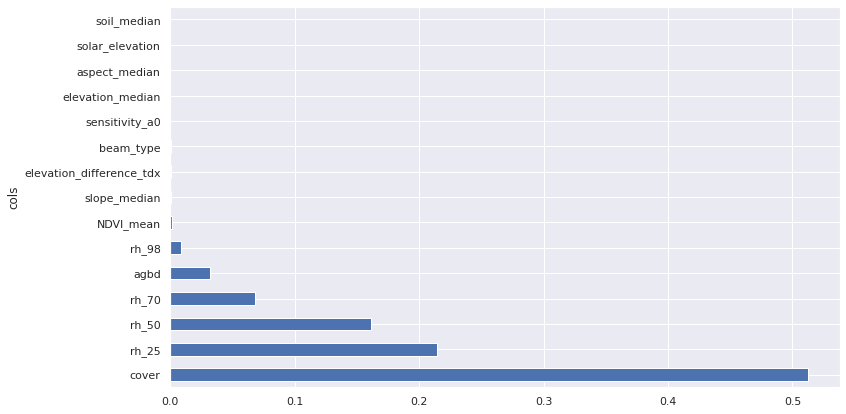

In [151]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

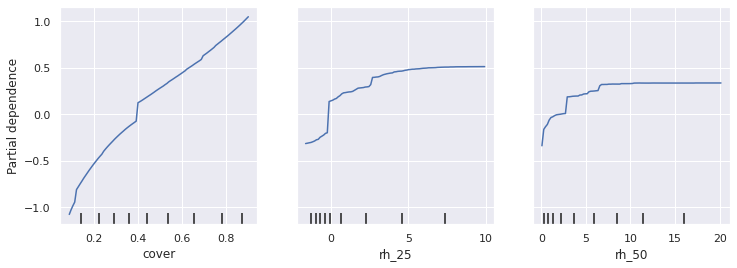

In [152]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['cover', 'rh_25', 'rh_50'], ax=ax)
# plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

# Predicting NDVI with everyyyything

Predicted NDVI with 0.55 R^2. The number one predictor is elevation! Followed by rh70, AGBD and rh50.

In [121]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use].dropna()

In [122]:
dep_var = 'NDVI_mean'
df = df[df[dep_var] != 0]
df[dep_var] = np.log(df[dep_var])
df = df.dropna()
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.126793 0.5541076485336538


                        cols       imp
12          elevation_median  0.255419
3                      rh_70  0.169503
1                       agbd  0.145270
4                      rh_50  0.135088
14               soil_median  0.040065
7                        pai  0.035145
13              slope_median  0.034179
6                      cover  0.033921
8   elevation_difference_tdx  0.032702
5                      rh_25  0.031000


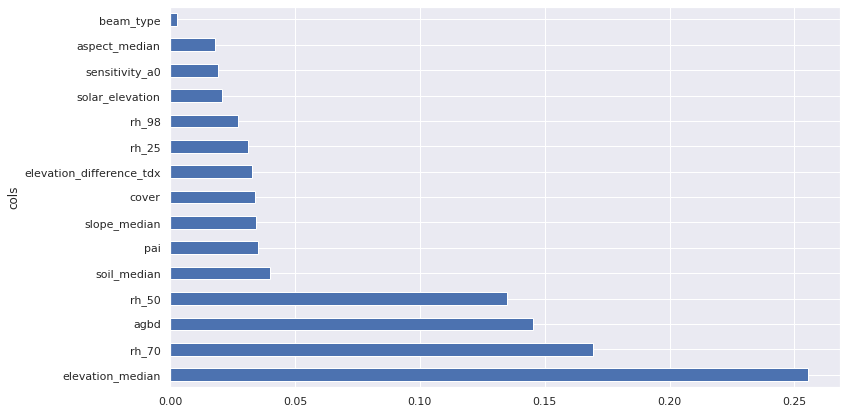

In [123]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

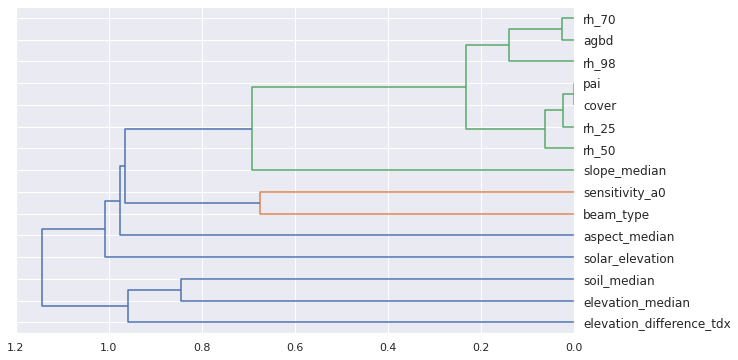

In [124]:
cluster_columns(xs)

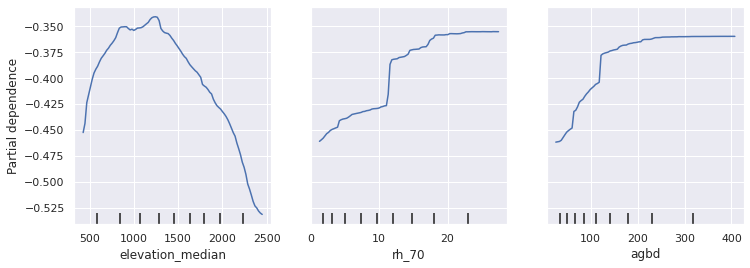

In [125]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_median', 'rh_70', 'agbd'], ax=ax)
# plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

## Predicting AGBD

## Predicting AGBD with elevation diff tdx but no NDVI

R^2 of 0.5.

In [74]:
columns_to_use = ['agbd',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [75]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.596734 0.5026825166352913


                       cols       imp
3  elevation_difference_tdx  0.641861
8              slope_median  0.116216
7          elevation_median  0.089293
5            sensitivity_a0  0.069599
4           solar_elevation  0.030465
6             aspect_median  0.028750
9               soil_median  0.013378
0                 beam_type  0.010425
2           slope_median_na  0.000007
1          aspect_median_na  0.000006


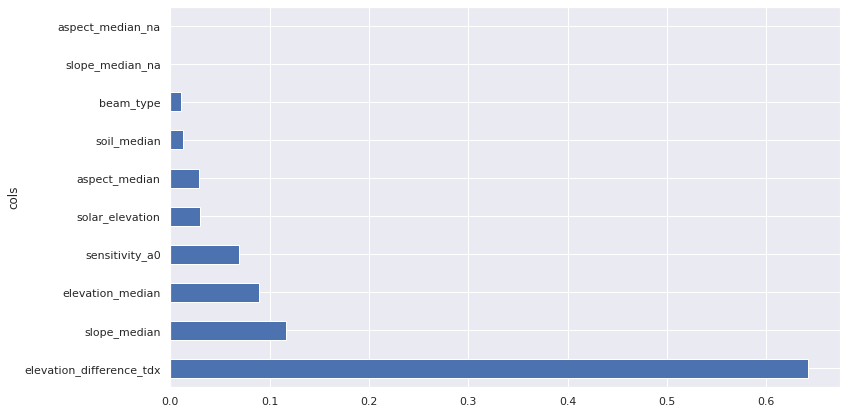

In [76]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

## Predicting AGBD without NDVI

Without NDVI, we finally end with 0.312 prediction for AGBD.

In [126]:
columns_to_use = ['agbd',
                  'beam_type',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [127]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.701595 0.3125428684965109


               cols       imp
6  elevation_median  0.276775
7      slope_median  0.253474
4    sensitivity_a0  0.183666
3   solar_elevation  0.116287
5     aspect_median  0.074064
8       soil_median  0.068882
0         beam_type  0.026715
2   slope_median_na  0.000069
1  aspect_median_na  0.000068


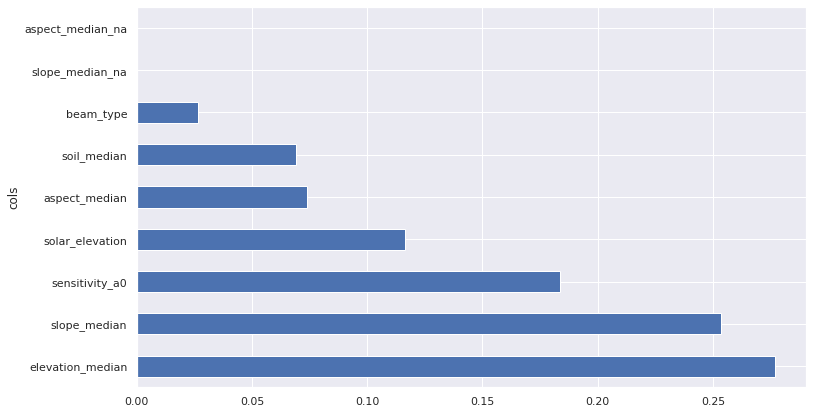

In [73]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

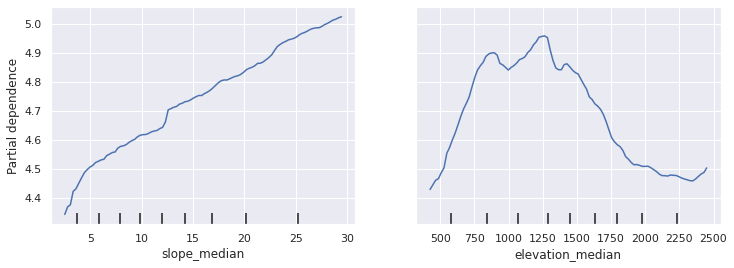

In [129]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['slope_median', 'elevation_median'], ax=ax)
# plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

## Predicting AGBD without elevation_difference_tdx

R^2 then further decreases to 0.43, with NDVI being the dominant predictor.

In [66]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'beam_type',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [67]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.633731 0.4391037021982126


                cols       imp
4          NDVI_mean  0.611622
9       slope_median  0.099923
8   elevation_median  0.099783
6     sensitivity_a0  0.080611
5    solar_elevation  0.043070
7      aspect_median  0.036574
10       soil_median  0.016275
0          beam_type  0.012066
2   aspect_median_na  0.000039
3    slope_median_na  0.000037


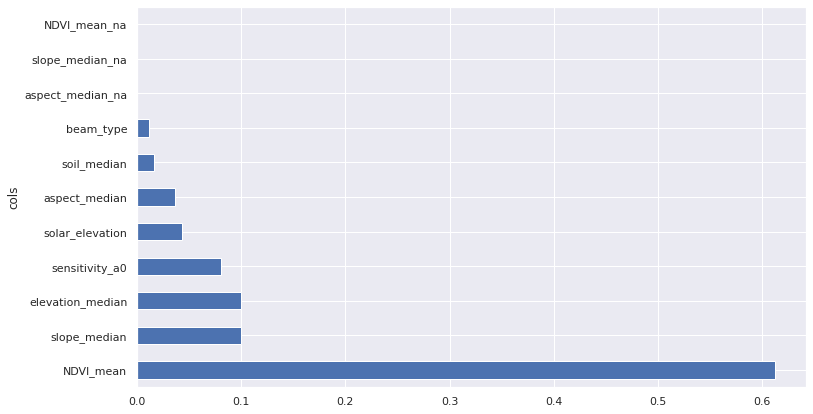

In [68]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

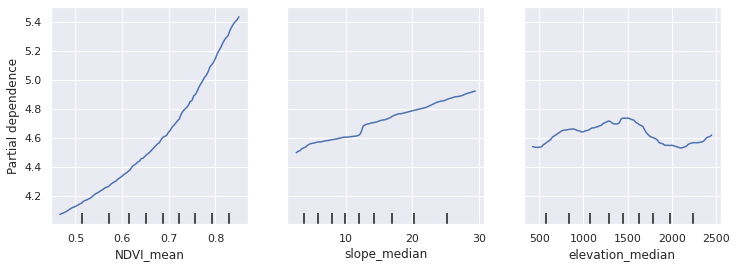

In [70]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['NDVI_mean', 'slope_median', 'elevation_median'], ax=ax)
# plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

## Predict AGBD without any other GEDI metrics

Once GEDI metrics are gone, we only achieve R^2 of 0.56, and elevation_difference_tdx becomes the dominant predictor, together with NDVI. 

I assume this is because elevation_difference_tdx is in a way, a GEDI measurement of ground, which subsequently affects all other estimates.

In [60]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [61]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.559178 0.5633108212770868


                        cols       imp
5   elevation_difference_tdx  0.469766
4                  NDVI_mean  0.320583
10              slope_median  0.073779
9           elevation_median  0.044431
7             sensitivity_a0  0.042115
8              aspect_median  0.019222
6            solar_elevation  0.018818
0                  beam_type  0.007577
11               soil_median  0.003695
2           aspect_median_na  0.000008


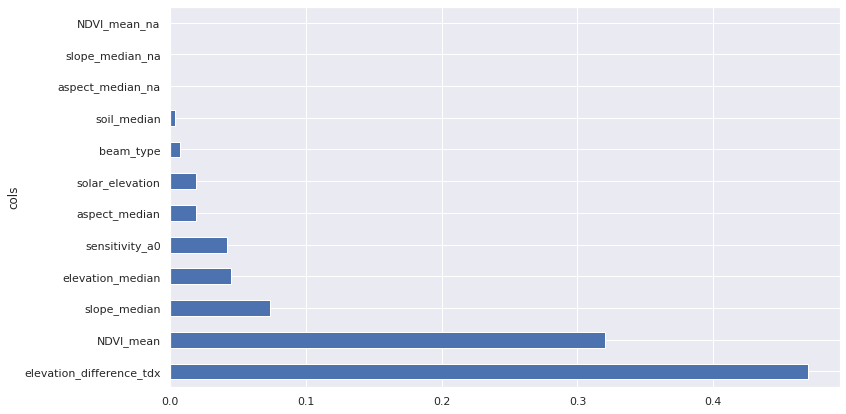

In [62]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

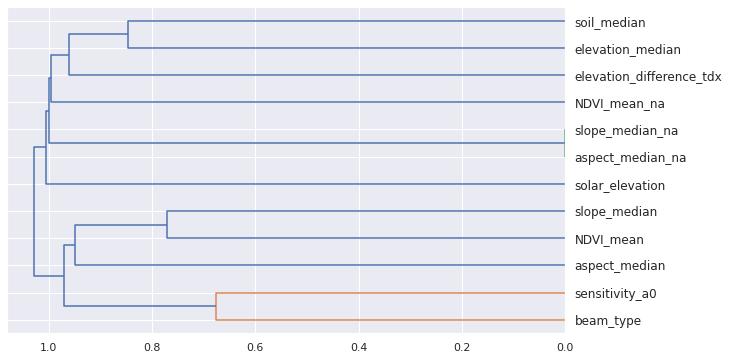

In [63]:
cluster_columns(xs)

## Predict AGBD without any RH metrics

0.83 R^2, based on pai and cover.

In [50]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'cover', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [51]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.343332 0.8353735528068631


                        cols       imp
6                        pai  0.405882
5                      cover  0.327224
7   elevation_difference_tdx  0.121240
4                  NDVI_mean  0.062096
11          elevation_median  0.025210
0                  beam_type  0.019766
12              slope_median  0.016590
9             sensitivity_a0  0.012482
10             aspect_median  0.004099
8            solar_elevation  0.003938


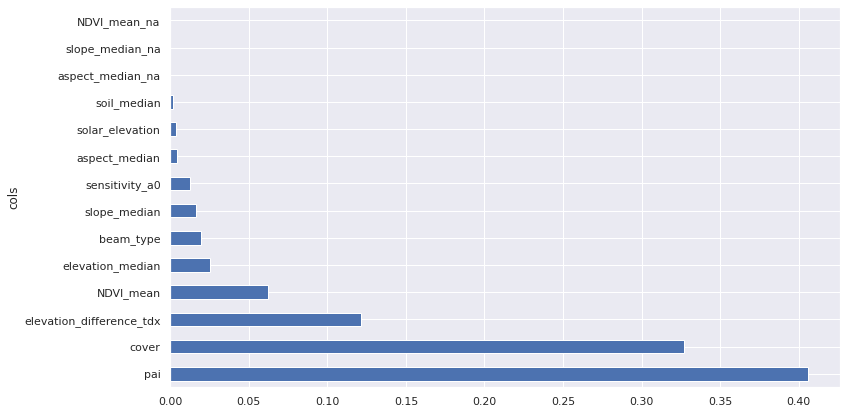

In [52]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

# Predict AGBD without RH70 and RH98

0.90 R^2 - derived from RH50, pai, cover and RH25.

In [46]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'rh_50', 'rh_25', 'cover', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [47]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


0.257133 0.9076604570240087


                        cols       imp
5                      rh_50  0.486515
8                        pai  0.198412
7                      cover  0.147903
6                      rh_25  0.063142
9   elevation_difference_tdx  0.049926
13          elevation_median  0.017224
0                  beam_type  0.010640
4                  NDVI_mean  0.007939
14              slope_median  0.007486
11            sensitivity_a0  0.007130


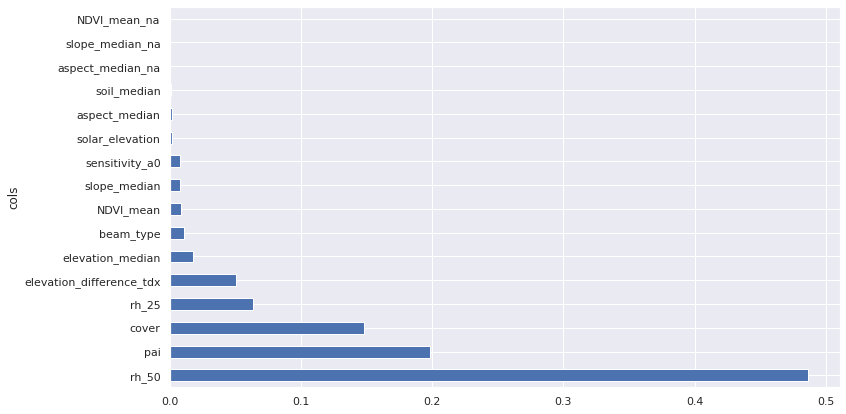

In [49]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

## Predict AGBD just from RH 70 and RH 98

Rh70 and RH 98 are sufficient to predict.

In [38]:
columns_to_use = ['agbd',
                  'rh_98', 'rh_70']
df = gedi_unburned[columns_to_use]

In [40]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])

In [43]:
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)

In [44]:
xs, y = to.train.xs, to.train.y
m = rf(xs, y)
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

0.000698 0.9999863731506351


<AxesSubplot: ylabel='cols'>

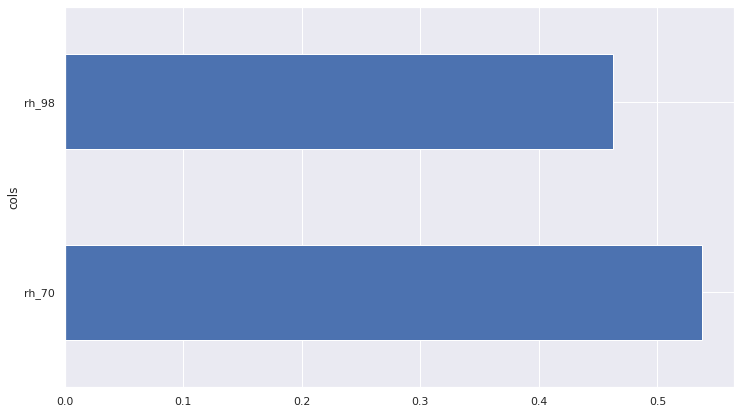

In [45]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])

## Predict AGBD using all variables

Results: R^2, not suprisingly, ends up being 0.9999. Two more important predictors are RH70, and RH98.

In [130]:
columns_to_use = ['agbd',
                  'NDVI_mean',
                  'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover', 'pai',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median']
df = gedi_unburned[columns_to_use]

In [131]:
dep_var = 'agbd'
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])

In [132]:
df['beam_type'] = df['beam_type'].astype('category')
df["beam_type"] = df['beam_type'].cat.set_categories(["full", "coverage"], ordered=True)

In [133]:
procs = [Categorify, FillMissing]

In [134]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [135]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


In [136]:
xs, y = to.train.xs, to.train.y

In [137]:
def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [138]:
m = rf(xs, y)

In [139]:
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

0.005038 0.9999645518518891


In [29]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [30]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
6,rh_70,0.556845
5,rh_98,0.259994
7,rh_50,0.078755
9,cover,0.051089
10,pai,0.045417
8,rh_25,0.006100
11,elevation_difference_tdx,0.001362
15,elevation_median,0.000193
0,beam_type,0.000137
16,slope_median,0.000041


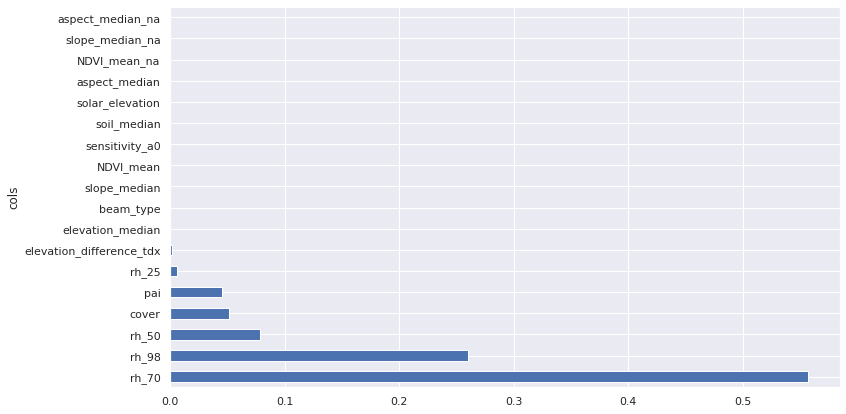

In [32]:

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])

In [31]:
df.drop(columns="beam_type").corr()

,agbd,NDVI_mean,rh_98,rh_70,rh_50,rh_25,cover,pai,elevation_difference_tdx,solar_elevation,sensitivity_a0,aspect_median,elevation_median,slope_median,soil_median
agbd,1.000000,0.511719,0.911340,0.936695,0.812215,0.673809,0.783272,0.687002,-0.504253,-0.007553,0.208133,0.011730,-0.049035,0.259103,-0.048980
NDVI_mean,0.511719,1.000000,0.441283,0.512075,0.504022,0.418978,0.436505,0.387267,-0.310513,0.004643,0.162382,0.023177,-0.211072,0.207081,-0.084492
rh_98,0.911340,0.441283,1.000000,0.832767,0.693897,0.562609,0.581163,0.527323,-0.520823,-0.022151,0.217880,0.001386,0.040547,0.193752,-0.049958
rh_70,0.936695,0.512075,0.832767,1.000000,0.912373,0.747652,0.764926,0.703786,-0.504391,-0.006283,0.178618,0.016262,-0.109116,0.271452,-0.042838
rh_50,0.812215,0.504022,0.693897,0.912373,1.000000,0.876985,0.812592,0.794334,-0.463735,-0.007229,0.186267,0.021037,-0.182252,0.332607,-0.028495
rh_25,0.673809,0.418978,0.562609,0.747652,0.876985,1.000000,0.835226,0.888148,-0.402970,-0.009263,0.187003,0.017615,-0.194117,0.362385,-0.006053
cover,0.783272,0.436505,0.581163,0.764926,0.812592,0.835226,1.000000,0.952089,-0.402903,-0.003813,0.199088,0.029304,-0.176020,0.381663,-0.019078
pai,0.687002,0.387267,0.527323,0.703786,0.794334,0.888148,0.952089,1.000000,-0.384572,-0.011218,0.196938,0.027901,-0.169884,0.393131,-0.008719
elevation_difference_tdx,-0.504253,-0.310513,-0.520823,-0.504391,-0.463735,-0.402970,-0.402903,-0.384572,1.000000,0.014895,-0.108439,0.029183,0.016229,-0.186896,0.036519
solar_elevation,-0.007553,0.004643,-0.022151,-0.006283,-0.007229,-0.009263,-0.003813,-0.011218,0.014895,1.000000,-0.068229,-0.001160,-0.022265,-0.003084,-0.015337


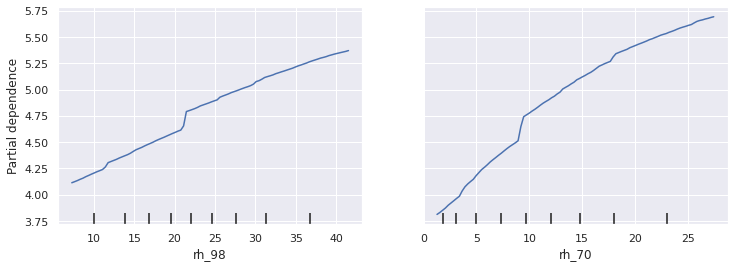

In [33]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['rh_98', 'rh_70'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

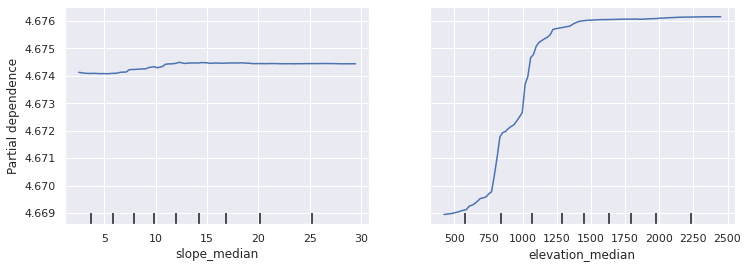

In [140]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['slope_median', 'elevation_median'], ax=ax)
# plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

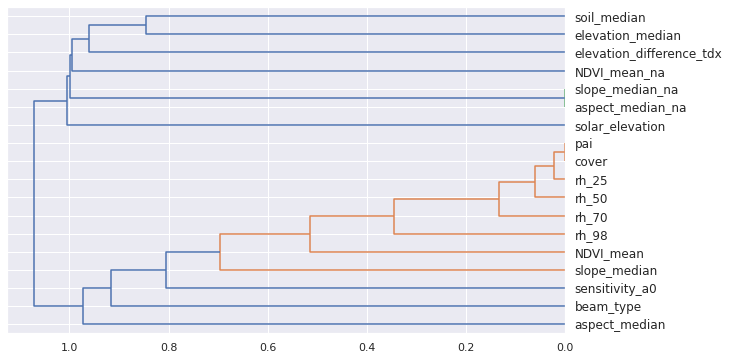

In [36]:
from fastbook import *
cluster_columns(xs)
